[https://www.tensorflow.org/hub/tutorials/movenet?hl=ko](https://www.tensorflow.org/hub/tutorials/movenet?hl=ko)

# 1. 패키지 import

In [ ]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
import tensorflow as tf
#  사전 학습된 모델을 쉽게 불러올 수 있는 라이브러리(pip install numpy==1.26.4)
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!unzip /content/drive/MyDrive/data/04_mpii.zip -d /content/drive/MyDrive/data/mpii/

Archive:  /content/drive/MyDrive/data/04_mpii.zip
   creating: /content/drive/MyDrive/data/mpii/train/lying/
  inflating: /content/drive/MyDrive/data/mpii/train/lying/012032666.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/017112242.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/020679637.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/023325432.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/030980688.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/034948298.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/035378916.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/038187175.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/038912301.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/039814928.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/052385561.jpg  
  inflating: /content/drive/MyDrive/data/mpii/train/lying/052700762.jpg  
  i

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#  TensorFlow Hub에서 사전 학습된 모델을 다운로드 및 로드
# https://tfhub.dev/google/movenet/singlepose/lightning/4 : MoveNet모델의 SinglePose Lightning 버전
# MoveNet은 구글에서 만든 경량화된 실시간 포즈 추정 모델
# Lightning은 빠르지만 정확도가 살짝 낮은 모델이고, Thunder는 조금 느리지만 더 정확
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = module.signatures['serving_default']

# 2. Movenet의 Pose Detect 테스트

# 2-1. detect_pose 함수

In [45]:
def detect_pose(image):

    # input_image = tf.image.resize_with_pad(image, 192, 192)
    input_image = tf.image.resize(image, [192, 192])
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run model inference
    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints

In [46]:
image = cv2.imread("/content/drive/MyDrive/data/sam/sample2.jpg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = tf.convert_to_tensor(image, dtype=tf.float32)

In [47]:
image.shape

(1080, 1920, 3)

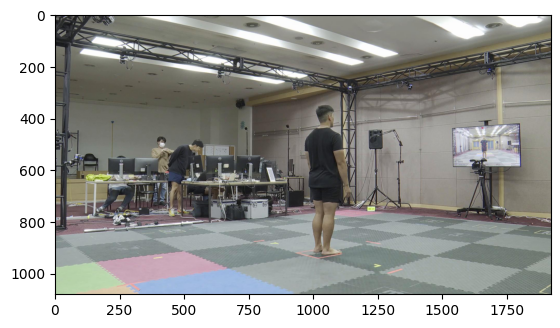

In [48]:
plt.imshow(image)

In [49]:
keypoints = detect_pose(input_image)

In [50]:
print(keypoints)

[[[[0.39230573 0.5499402  0.20843789]
   [0.38607237 0.54109436 0.24065821]
   [0.38425454 0.55501914 0.22244918]
   [0.39504415 0.5200732  0.3941902 ]
   [0.38807952 0.5509221  0.5764212 ]
   [0.43296367 0.5104932  0.5101905 ]
   [0.43493146 0.5580311  0.46216395]
   [0.5113715  0.5033359  0.32561472]
   [0.502756   0.561541   0.31284362]
   [0.57786685 0.51529783 0.17607404]
   [0.5744419  0.5581668  0.18703888]
   [0.5837717  0.51160955 0.3449166 ]
   [0.5834383  0.5458194  0.43983206]
   [0.7128426  0.52932984 0.34247783]
   [0.71010345 0.5526281  0.30062905]
   [0.8305563  0.5319166  0.39317158]
   [0.83501333 0.5481693  0.31983152]]]]


In [51]:
height, width, confidence = image.shape
height, width, confidence

(1080, 1920, 3)

# 2-2. pose class 및 edge 색상 정의

In [52]:
m = (255, 0, 255)
c = (0, 255, 255)
y = (255, 255, 0)

KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGES = {
    (0, 1): m,
    (0, 2): c,
    (1, 3): m,
    (2, 4): c,
    (0, 5): m,
    (0, 6): c,
    (5, 7): m,
    (7, 9): m,
    (6, 8): c,
    (8, 10): c,
    (5, 6): y,
    (5, 11): m,
    (6, 12): c,
    (11, 12): y,
    (11, 13): m,
    (13, 15): m,
    (12, 14): c,
    (14, 16): c
}

# 2-3. draw_keypoints 함수

In [53]:
def draw_keypoints(image, keypoints):
    height, width, confidence = image.shape
    for person in keypoints[0]:
        for edge, color in KEYPOINT_EDGES.items():
            p1, p2 = edge
            y1, x1, c1 = person[p1]
            y2, x2, c2 = person[p2]
            # if c1 > 0.5 and c2 > 0.5:  # Draw lines only for keypoints with confidence > 0.5
            start_point = (int(x1 * width), int(y1 * height))
            end_point = (int(x2 * width), int(y2 * height))
            cv2.line(image, start_point, end_point, color, 2)

        for keypoint in person:
            y, x, c = keypoint
            # if c > 0.5:  # Draw only keypoints with confidence > 0.5
            cv2.circle(image, (int(x * width), int(y * height)), 5, (0, 255, 0), -1)

    return image

# 2-4. 결과 확인

In [54]:
image_keypoints = draw_keypoints(image, keypoints)
image_keypoints.shape

(1080, 1920, 3)

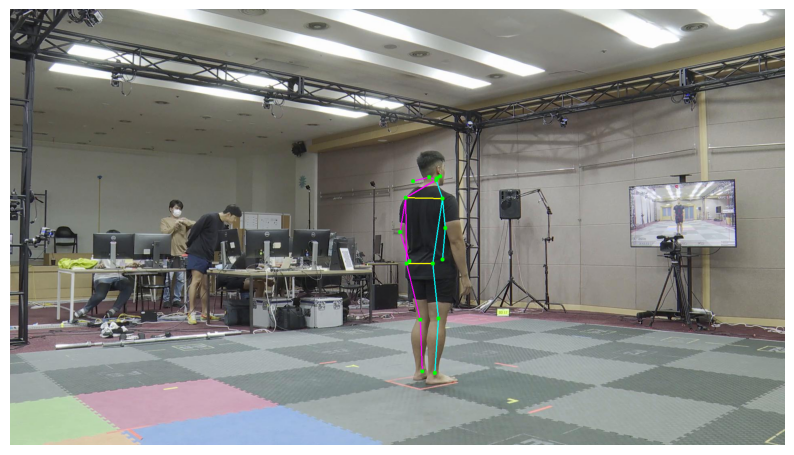

In [55]:
plt.figure(figsize=(10, 10))
# image_keypoints = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB)
plt.imshow(image_keypoints)
plt.axis('off')
plt.show()

# 3. 폴더 내 이미지 전처리

# 3-1. 폴더 내 이미지 불러오기

In [56]:
import glob
import os
import pandas as pd

In [58]:
train_path = '/content/drive/MyDrive/data/sam'

In [59]:
for x in os.walk(train_path):
    print(x)

('/content/drive/MyDrive/data/sam', [], ['sample1.jpg', 'sample2.jpg'])


In [60]:
train_x_path = []
train_y = []

for x in os.walk(train_path):
    if len(x[2])==0:
        continue

    name = os.path.basename(x[0])

    for file_name in x[2]:
        image_full_path = train_path + "/" + name + "/" + file_name
        train_x_path.append(image_full_path)
        train_y.append(name)

print(len(train_y))
print(len(train_x_path))
print(train_y)
print(train_x_path)

2
2
['sam', 'sam']
['/content/drive/MyDrive/data/sam/sam/sample1.jpg', '/content/drive/MyDrive/data/sam/sam/sample2.jpg']
